In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (20, 120, -10, -50))
camera = game_env.camera

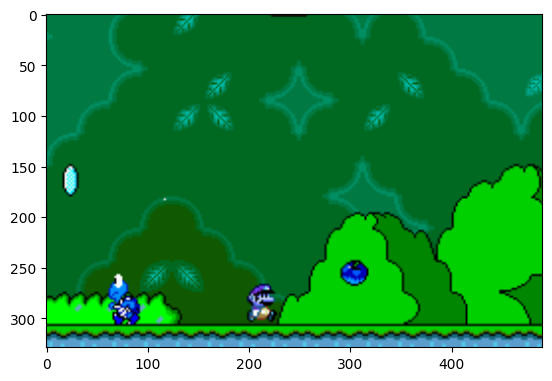

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
D = 40_000
GAMMA = 0.99
LR = 0.000003

# NUM_EPISODES = 10000
SEQUENCE_LENGTH = 100
BATCH_SIZE = 100

EPS_NUM_STEPS = 2000
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)

action_space = 2 # 4

load_model = False
model_name = "2023_12_26_23_13_56"

In [8]:
import time
from itertools import count
from tensorboardX import SummaryWriter


timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

In [9]:
from src.memory import Memory, PrioritizedReplayMemory

# Initiliaze replay memory D to capacity N
replay_memory = PrioritizedReplayMemory(D, device, queue_push_thread=True)
sequence = Memory(SEQUENCE_LENGTH)

queue thread enabled


In [10]:
from src.models.batch_model import DQN, phi, PromptQValues
from torch import nn

# Initialize action-value function Q with random weights

lstm_n = 4096 #512
lstm_layers = 2

policy_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta
target_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

global steps
steps = 0
episode = 0

(120, 200, 3)
tensor([-1.0490e-08, -1.3987e-08, -8.1380e-08], device='cuda:0') tensor([1., 1., 1.], device='cuda:0')


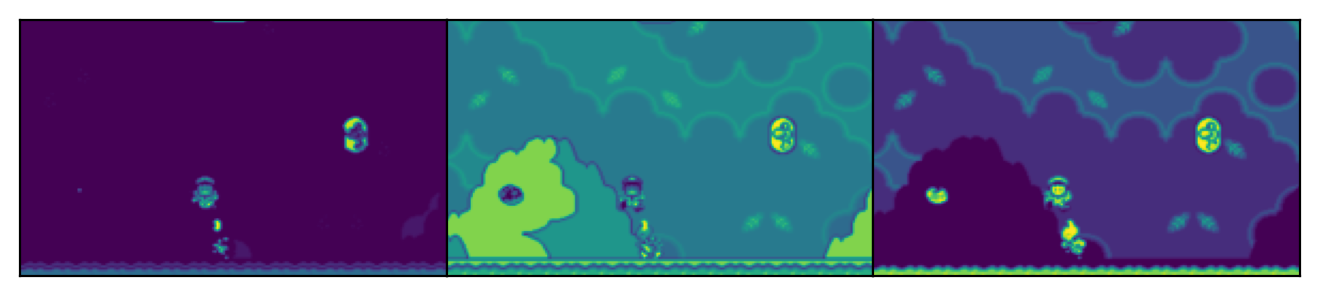

In [11]:
camera.set_foreground_game()
frame = camera.get_frame()
img = phi(observation=frame, device=device)
mean, std = img.mean([1,2]), img.std([1,2])
img = img.cpu().numpy()
img = img.transpose((1,2,0))
print(img.shape)
print(mean, std)

fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0}, dpi=200)
axes[0].imshow(img[:,:,0])
axes[1].imshow(img[:,:,1])
axes[2].imshow(img[:,:,2])
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [12]:
def assert_sequence(sequence: Memory):
    if len(sequence) == SEQUENCE_LENGTH:
        sequence_state = sequence.render_simple()
        for i in range(len(sequence_state)):
            print(f"{i}")
            plt.imshow(sequence_state[i].cpu().numpy().transpose((1,2,0)))
            plt.show()
        input()

In [13]:
#prompt_q_values = PromptQValues()

In [14]:
import datetime

loss = 0
policy_net.train()
writer = SummaryWriter(logdir="runs/"+timestr)

global thread_running
thread_running = False

def play():
    global thread_running
    episode = 0
    epsilon = EPS_START
    steps = 0
    time.sleep(2)
    camera.set_foreground_game()
    time.sleep(0.2)
    # with SummaryWriter(logdir="runs/"+timestr) as writer:
    try:
        while steps < D*50-50:
            ep_rewards = 0
            ep_qvalues = 0
            ep_loss = 0
            
            # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
            observation = game_env.reset()
            state = phi(observation, device)
            last_reward = 0
            # sequence.clear()
            
            print(thread_running)
            if not thread_running:
                return
            
            for t in count():
                step_time_start = time.perf_counter()
                # print(len(sequence), t)

                sequence.push(state)
                sequence_state = sequence.render_simple()

                # assert_sequence(sequence)

                hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
                cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

                with torch.no_grad():
                    
                    q_value_action, (hn, cn) = policy_net(sequence_state, (hn, cn))
                    q_value_action = q_value_action[-1:]
                    # prompt_q_values.set_qvalues(q_value_action[0].cpu().numpy())
                    q_value_action = q_value_action.max(1)
                    
                    q_value = q_value_action[0].item()
                    ep_qvalues += q_value
                
                # With probability eps select a random action at
                epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
                if random.uniform(0, 1) < epsilon:
                    action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
                # otherwise select at = maxaQ*(phi(st), a; teta)
                else:
                    action = q_value_action[1].view(1,1)
                    # print(action)

                # Execute action at in emulator and observe reward rt and image xt+1
                observation, reward, game_over = game_env.step(action.item())
                
                ep_rewards += reward
                #print(reward)
                reward = torch.tensor([reward], device=device, dtype=torch.float32)

                # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
                if game_over:
                    next_state = None # ordem provavelmente errada
                else:
                    next_state = phi(observation, device)
                    # sequence.push(next_state)
                    # rendered, next_sequence_state = sequence.render()

                #if sequence_state != None:
                # replay_memory.push((sequence_state, action, reward, next_sequence_state))
                
                replay_memory.push_queue(state, action, reward, next_state)
                
                # writer
                writer.add_scalar("Reward/reward", reward, steps)
                writer.add_scalar("Qvalue/qvalue", q_value, steps)
                writer.add_scalar("Epsilon/epsilon", epsilon, steps)
                if not game_over:
                    writer.add_scalar("Steps/Execution_Time", (time.perf_counter() - step_time_start), steps)
                writer.flush()
                
                # adding ep log
                ep_rewards += reward

                # sequence_state = next_sequence_state 
                state = next_state
                steps += 1
                if game_over:
                    
                    # ep log
                    ep_reward_mean = ep_rewards / (t+1)
                    writer.add_scalar("Episode/reward_mean", ep_reward_mean, episode)

                    break
            episode += 1
            # writer.flush()
    except Exception as e:
        print(e)
        thread_running = False
    
def train():

    global thread_running
    train_steps = 0

    while True:

        if not thread_running:
            return
        
        if len(replay_memory) > BATCH_SIZE: # and steps > 200:
            with replay_memory.memory_lock:
                loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample_sequence(BATCH_SIZE), GAMMA, lstm_n, lstm_layers, replay_memory, device).item()
            # ep_loss += loss
            writer.add_scalar("Loss/loss", loss, train_steps)
            """
            if (t+1) % SEQUENCE_LENGTH == 0:
                clear_output(wait=True)
                print('loss:', ep_loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', ep_rewards, 'ep:', episode)
                writer.add_scalar("Loss/ep_loss", ep_loss / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Reward/ep_rewards", ep_rewards / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Qvalue/ep_qvalues", ep_qvalues / SEQUENCE_LENGTH, steps)
                ep_rewards = 0
                ep_qvalues = 0
                ep_loss = 0
            """
            """
            if train_steps%100 == 0:
                clear_output(wait=True)
                print(f"loss: {loss}")
            """
            train_steps += 1
            if train_steps % 1_000 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            time.sleep(0.1)
        else:
            print("dont have sufficient memory to train...")
            time.sleep(1)


In [15]:
import threading

play_thread = threading.Thread(target=play, daemon=True)
train_thread = threading.Thread(target=train, daemon=True)

thread_running = True

play_thread.start()
train_thread.start()
replay_memory.start_queue_thread()
print("threads started...")

play_thread.join()
train_thread.join()
# replay_memory.thread.join()
print("threads ended.")

dont have sufficient memory to train...
threads started...
dont have sufficient memory to train...
dont have sufficient memory to train...
True
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
True
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
dont have sufficient memory to train...
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
mario - Sne

In [16]:
from src.models.batch_model import prompt_conv
sequence_state = replay_memory.sample_sequence(5)
print(len(sequence_state[0]))
# sequence_state = sequence.render_simple()
print(sequence_state[0])
prompt_conv(sequence_state)

5
(tensor([[[-0.4631, -0.4631, -0.4631,  ..., -0.4631, -0.4631, -0.4631],
         [-0.4631, -0.4631, -0.4631,  ..., -0.4631, -0.4631, -0.4631],
         [-0.4631, -0.4631, -0.4631,  ..., -0.4631, -0.4631, -0.4631],
         ...,
         [ 2.1883,  2.1883,  1.9354,  ...,  1.9518,  2.1763,  1.9361],
         [ 2.2692,  2.2692,  2.2632,  ...,  2.1027,  2.2390,  2.2631],
         [ 2.2692,  2.2692,  2.2692,  ...,  2.0625,  2.2311,  2.2692]],

        [[-0.4594, -0.4594, -0.4594,  ...,  0.0892,  0.0940,  0.1077],
         [-0.4594, -0.4594, -0.4594,  ...,  0.0892,  0.0892,  0.0892],
         [-0.4594, -0.4594, -0.4594,  ...,  0.0892,  0.0892,  0.0892],
         ...,
         [ 1.2854,  1.2854,  1.0547,  ...,  1.2139,  1.3025,  1.0591],
         [ 1.3576,  1.3576,  1.3521,  ...,  2.2682,  1.5385,  1.3525],
         [ 1.3576,  1.3576,  1.3576,  ...,  2.5371,  1.5932,  1.3576]],

        [[-0.5846, -0.5846, -0.5846,  ..., -0.0513, -0.0460, -0.0348],
         [-0.5846, -0.5846, -0.5846,  ...,

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')

In [ ]:
def assert_memory():
    sequence = replay_memory.sample_sequence(3)

    states, actions, rewards, next_states = *zip(*sequence), # let the ',' to not give syntax error
    sequence_length = len(states) # - 1

    states = torch.stack(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)

    non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
    non_final_next_states = torch.stack([s for s in next_states if s is not None])

    print(len(states))
    for i in range(len(states)):
        print(f"{i}")
        plt.imshow(states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
        plt.imshow(non_final_next_states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
assert_memory()

In [ ]:
exit()

In [ ]:
camera.set_foreground_game()

policy_net.eval()
while True:
    observation = game_env.reset()
    time.sleep(0.1)
    state = phi(observation, device)
    sequence.clear()
    
    for t in count():

        sequence.push(state)
        rendered = sequence.render_simple()

        hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        with torch.no_grad():
            q_value_action, (hn, cn) = policy_net.forward_prompt(rendered, (hn, cn))
            q_value_action = q_value_action[-1:]
            print(q_value_action, end="")
            q_value_action = q_value_action.max(1)
            action = q_value_action[1].view(1,1)
            print(f", actions {action}")

        observation, reward, game_over = game_env.step(action.item())
        if game_over:
            next_state = None # ordem provavelmente errada
        else:
            next_state = phi(observation, device)
        state = next_state
        if game_over:
            break

In [ ]:
"""camera.set_foreground_game()
state = phi(camera.get_frame(), device)

policy_net.eval()
hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

with torch.no_grad():
    q_value_action, (hn, cn) = policy_net(state.unsqueeze(0), (hn, cn))
    q_value_action = q_value_action[-1:]
    print(q_value_action)"""